##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\2.57"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

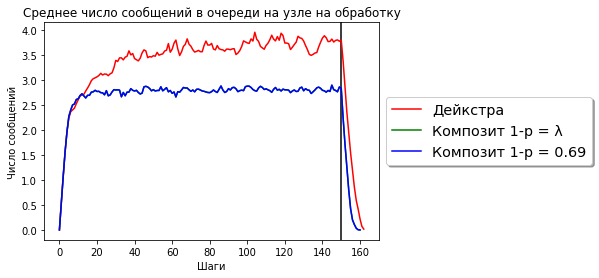

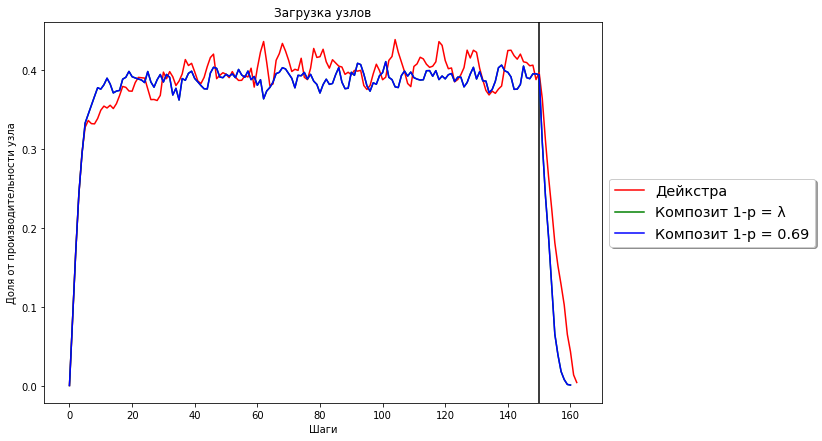

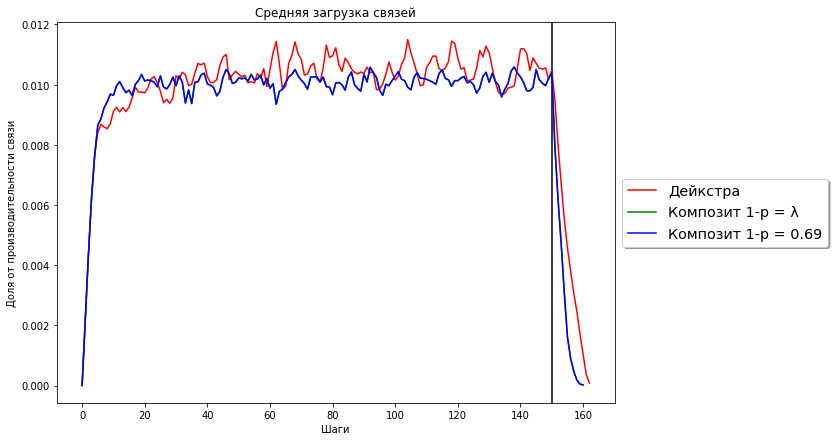

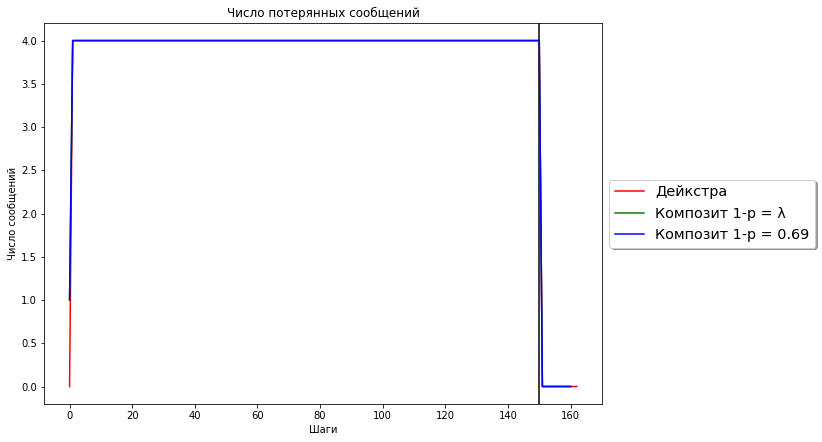

Доставлено 14401 Потеряно 3.9997% -Дейкстра
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = λ
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = 0.69


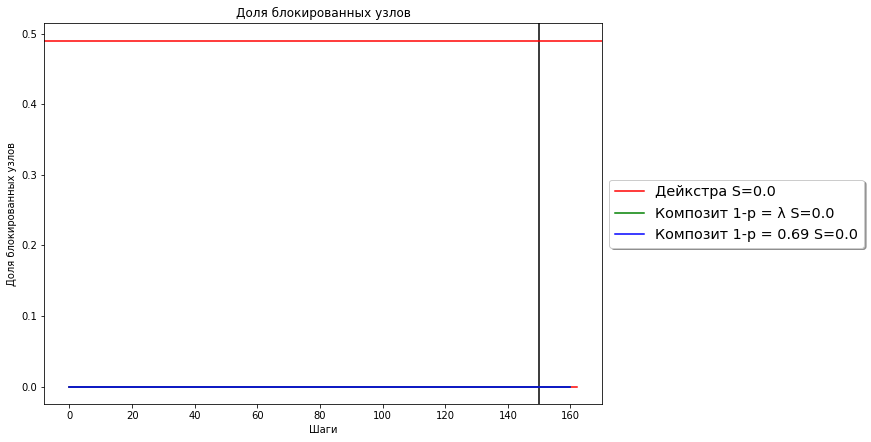

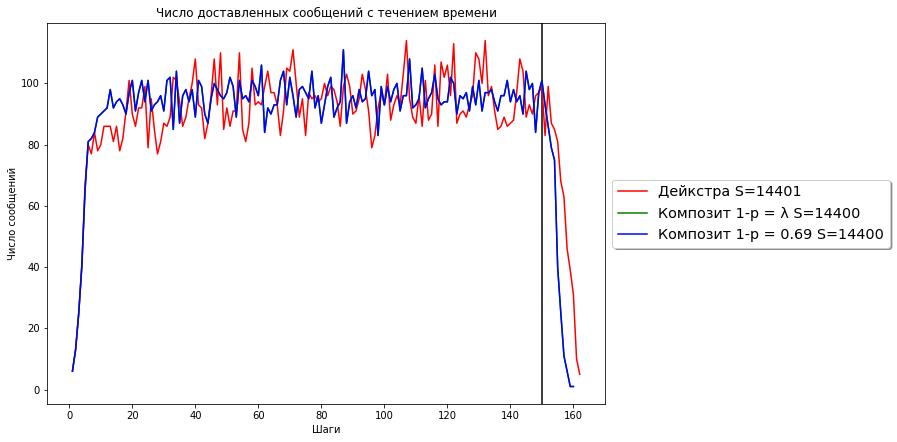

In [2]:
log_tags = [
 {"tag":  "cfc443dd-c7bb-409d-87b1-88c44337942c", "label": "Дейкстра", "color": "red"},
# {"tag":  "2b650059-299c-4719-a35e-8e60331d0d22", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "d8b07a76-1630-4502-aa81-395444c3269e", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "7b249420-22c5-419d-bb24-606779166e56", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
 
]
quantity = 100; 
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

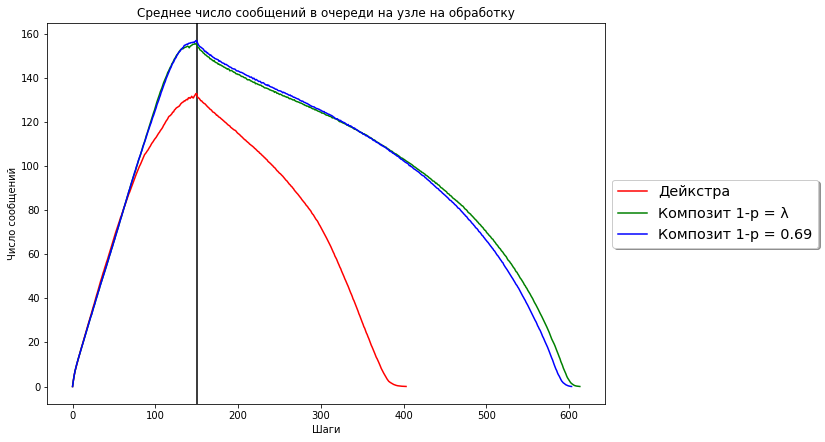

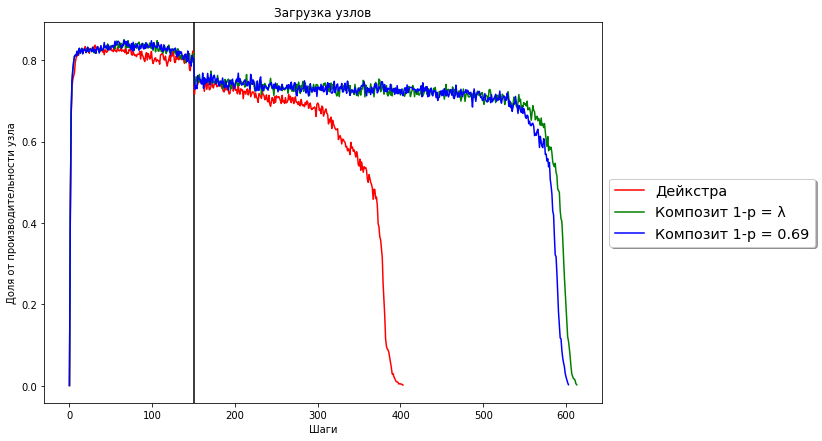

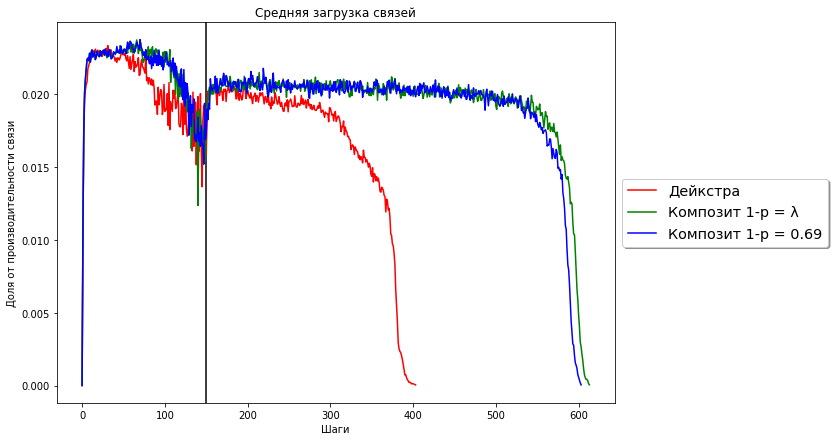

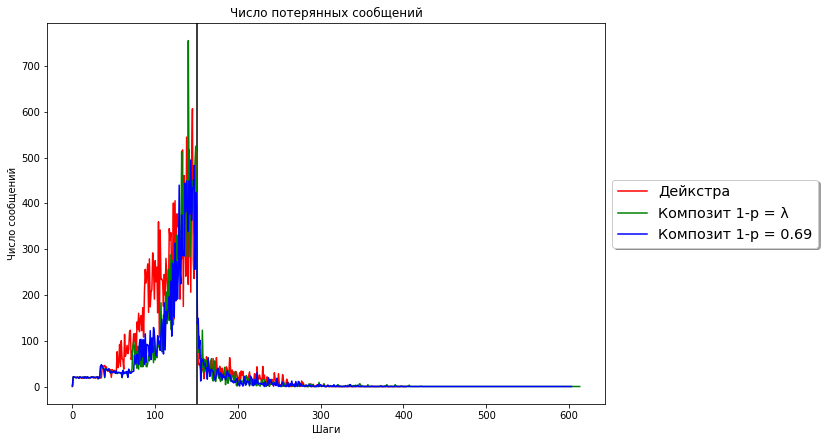

Доставлено 49117 Потеряно 34.5115% -Дейкстра
Доставлено 55113 Потеряно 26.5170% -Композит 1-p = λ
Доставлено 55831 Потеряно 25.5597% -Композит 1-p = 0.69


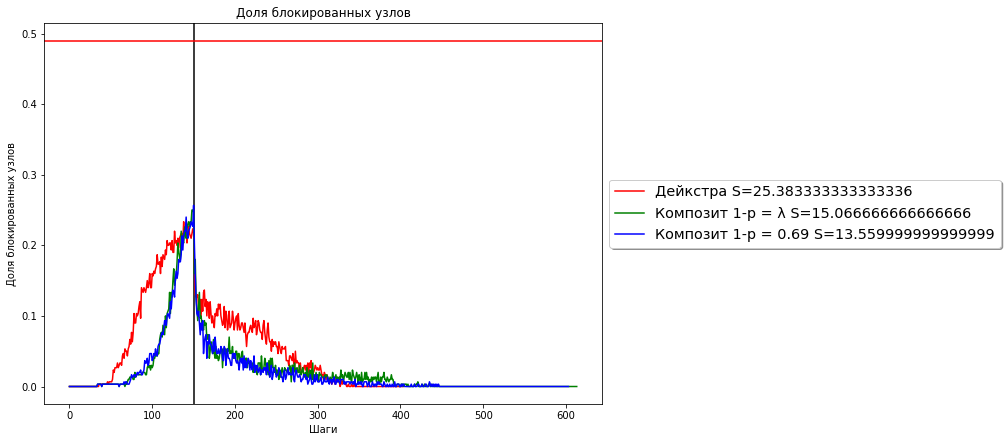

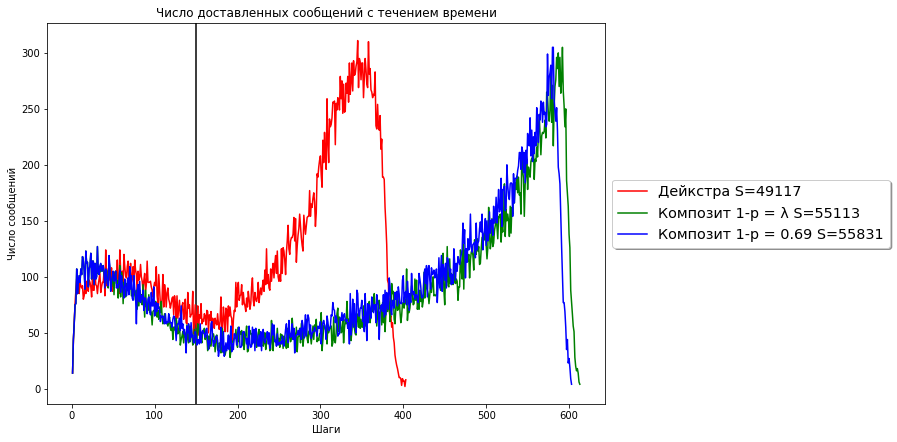

In [3]:
log_tags = [
 {"tag":  "306cefb3-40da-4356-bcd1-8b2e8199b6f7", "label": "Дейкстра", "color": "red"},
 #{"tag":  "07b446ae-f69e-436d-8eb0-5ef918e50bce", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "3f0608ca-c974-4354-8268-eacc59e33403", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "9849d499-58e2-4970-a6a7-b4afc9670d54", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

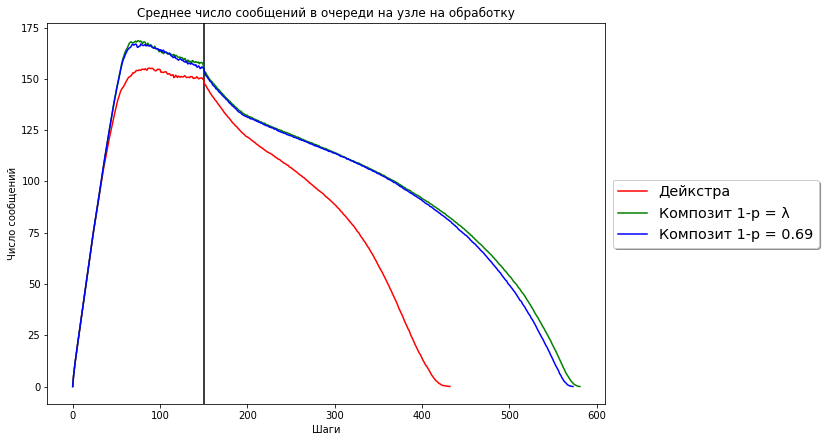

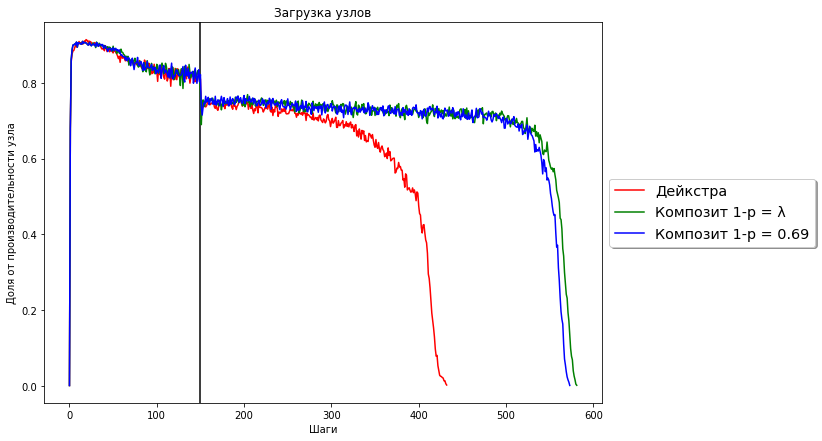

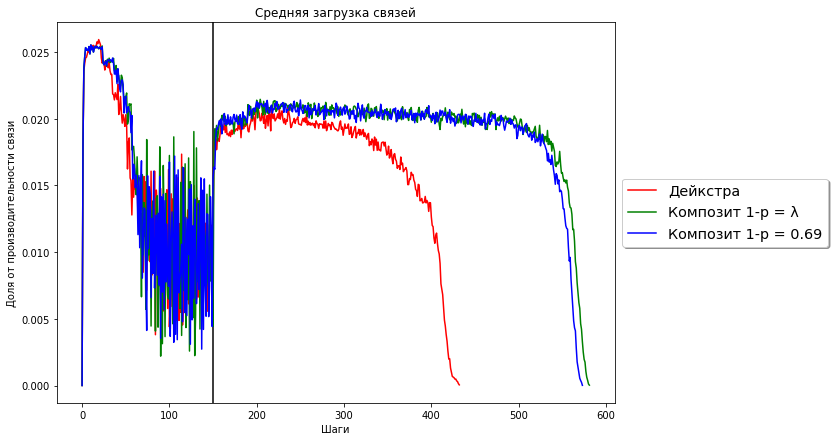

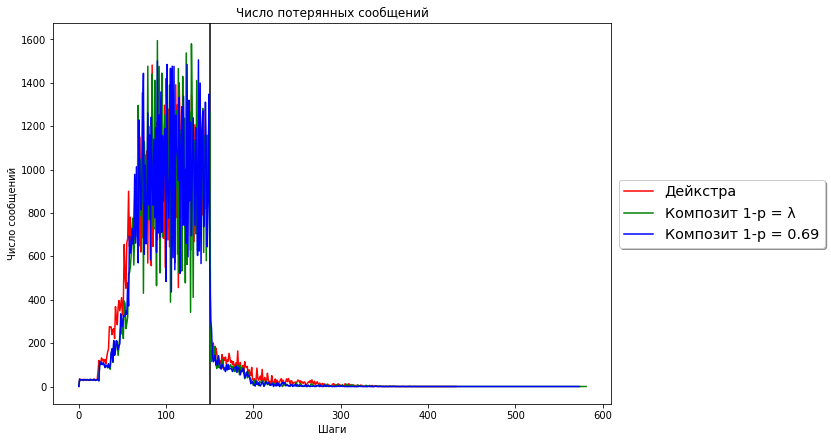

Доставлено 44372 Потеряно 70.4189% -Дейкстра
Доставлено 48265 Потеряно 67.8235% -Композит 1-p = λ
Доставлено 48454 Потеряно 67.6975% -Композит 1-p = 0.69


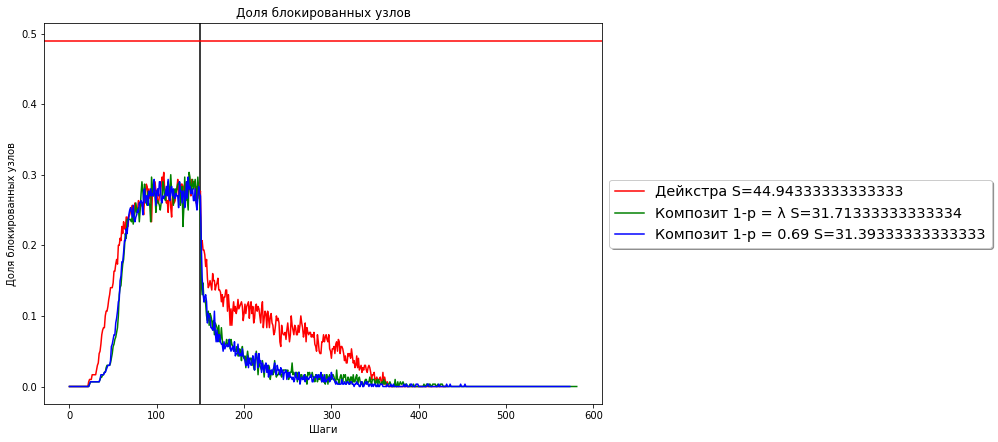

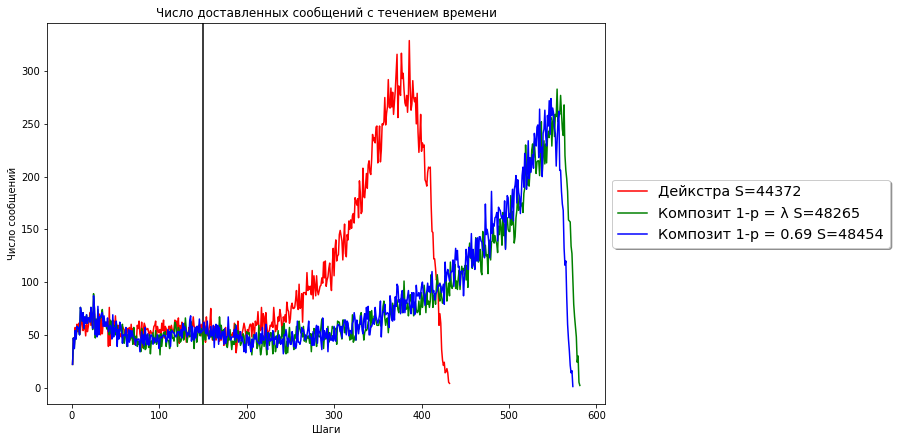

In [4]:
log_tags = [
 {"tag":  "aca1bd54-7a64-4823-938b-af0a3cee5a82", "label": "Дейкстра", "color": "red"},
 #{"tag":  "1155413f-6d21-499d-90b3-3e01b5de6bb3", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "70a48d71-e6ae-4e81-8a87-7886d8453e18", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "2628c4fe-611a-4066-969f-37189c32108b", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

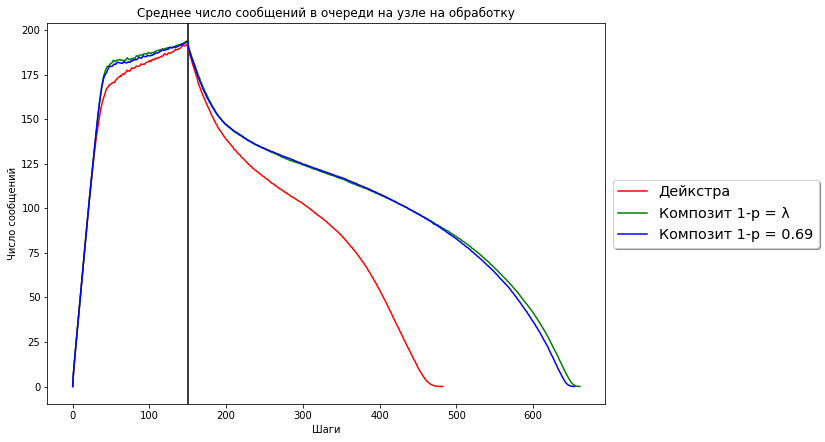

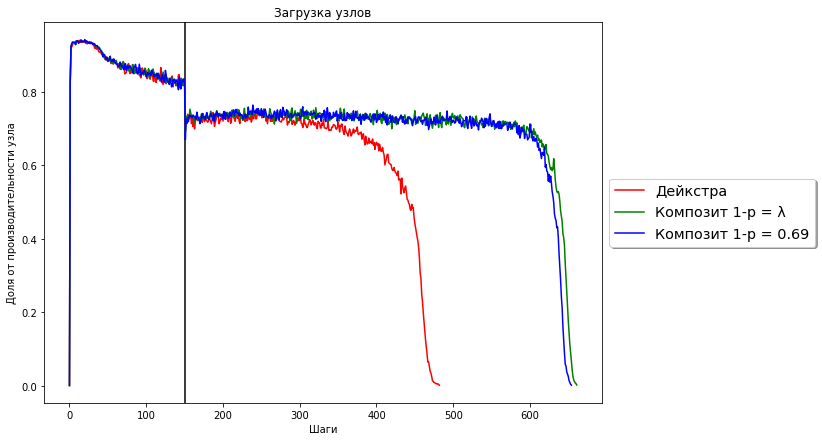

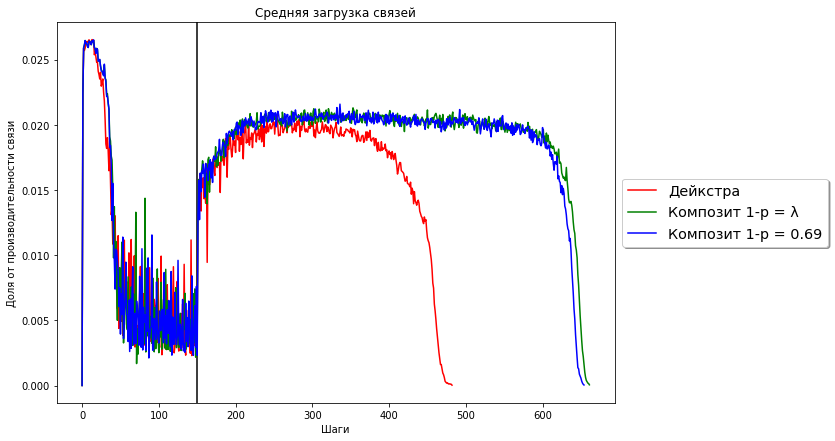

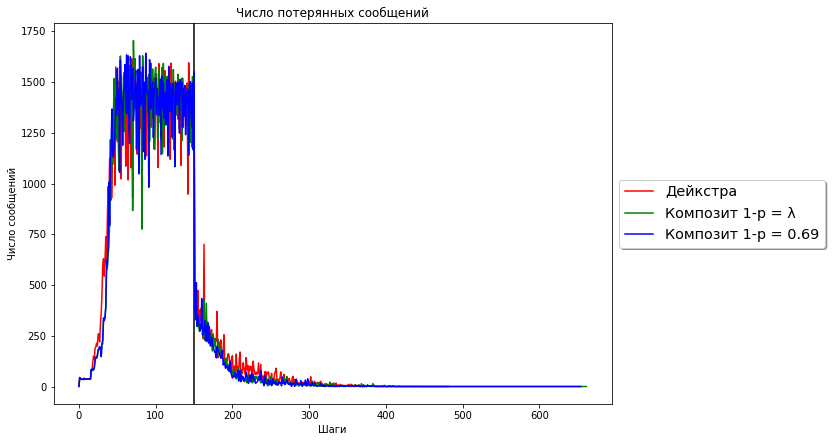

Доставлено 44946 Потеряно 80.0241% -Дейкстра
Доставлено 49660 Потеряно 77.9290% -Композит 1-p = λ
Доставлено 50009 Потеряно 77.7739% -Композит 1-p = 0.69


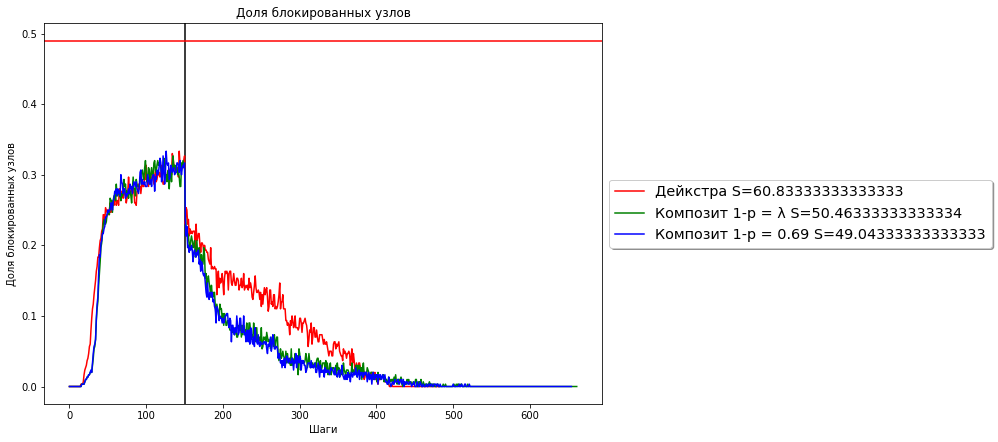

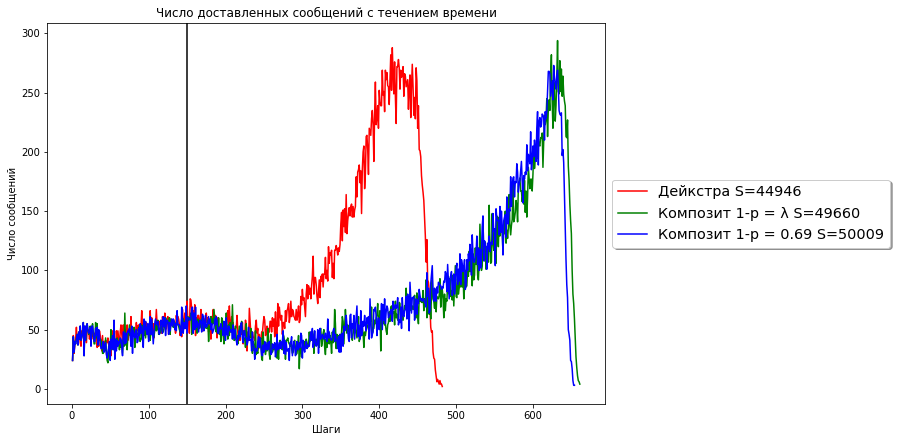

In [5]:
log_tags = [
 {"tag":  "f60808b5-99b7-4018-9780-742666e90154", "label": "Дейкстра", "color": "red"},
 #{"tag":  "4a376c54-9280-41b7-9d71-0bb8653f7014", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "b7ab1aae-fef2-40c0-81fe-abc7cf4427d2", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "49d0ecf8-26a2-403f-90c5-3c7d4669d0ed", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 41463 Потеряно 7.8620% -Дейкстра
Доставлено 43227 Потеряно 3.9421% -Композит 1-p = λ
Доставлено 43186 Потеряно 4.0332% -Композит 1-p = 0.69


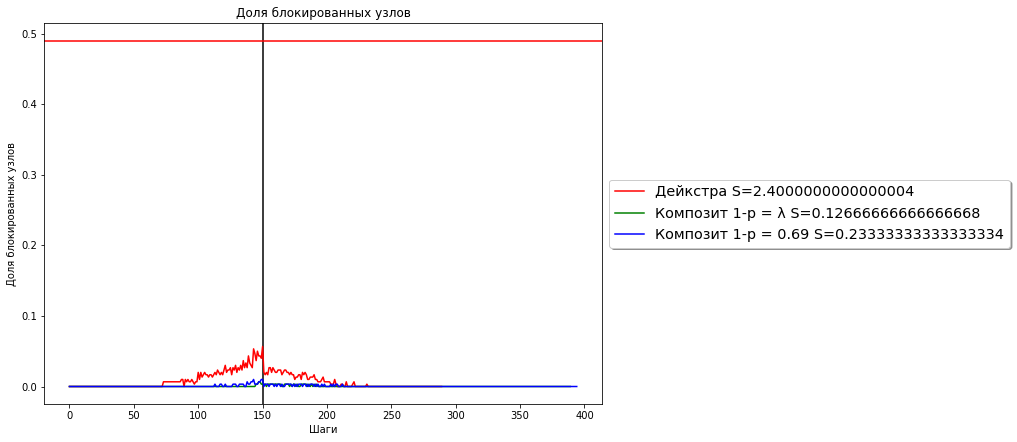

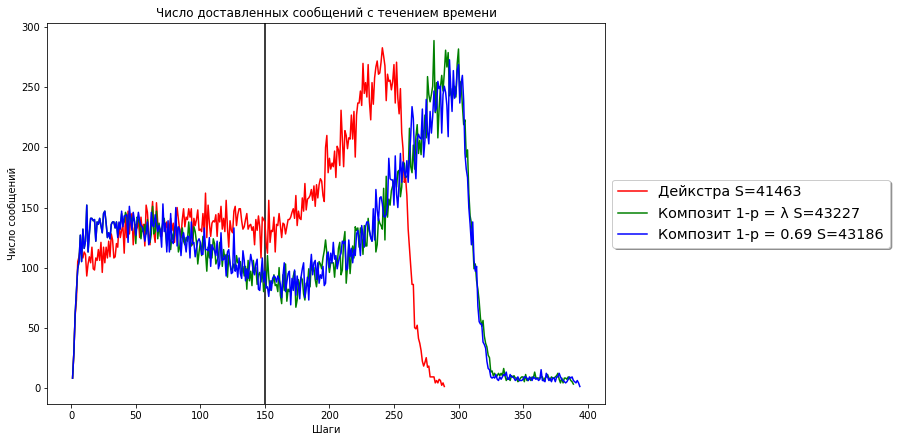

Доставлено 48476 Потеряно 53.8328% -Дейкстра
Доставлено 53199 Потеряно 49.3348% -Композит 1-p = λ
Доставлено 53727 Потеряно 48.8319% -Композит 1-p = 0.69


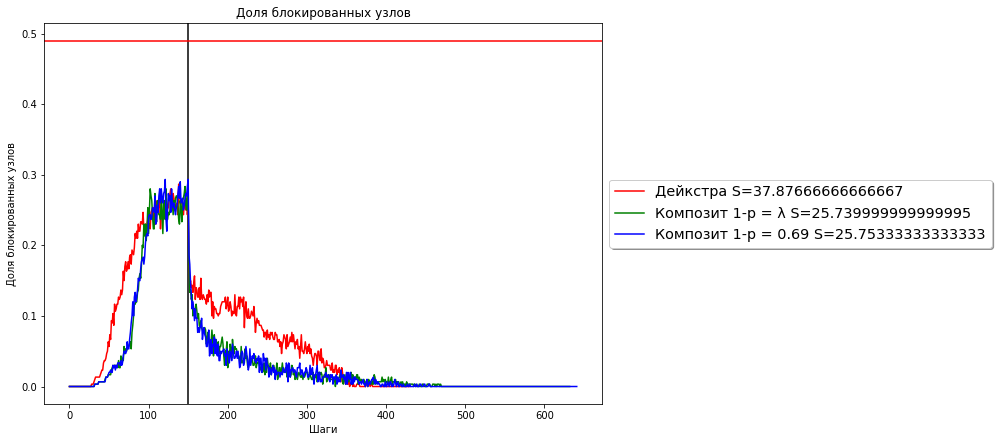

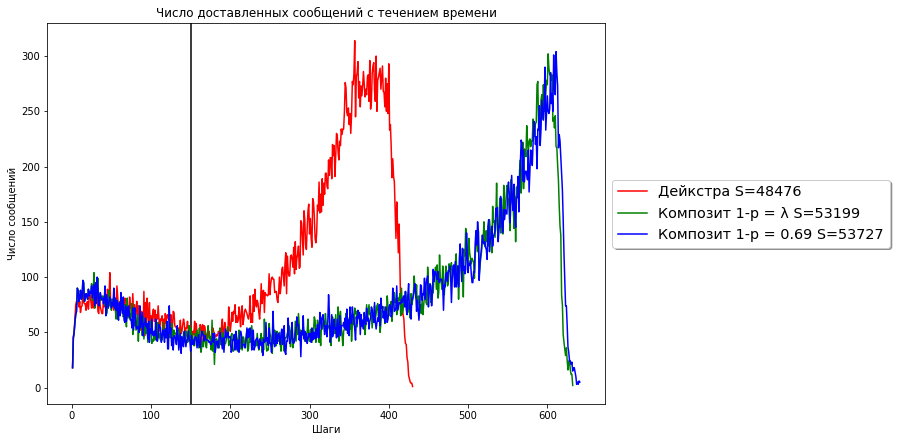

Доставлено 45434 Потеряно 66.3454% -Дейкстра
Доставлено 49680 Потеряно 63.2003% -Композит 1-p = λ
Доставлено 50279 Потеряно 62.7566% -Композит 1-p = 0.69


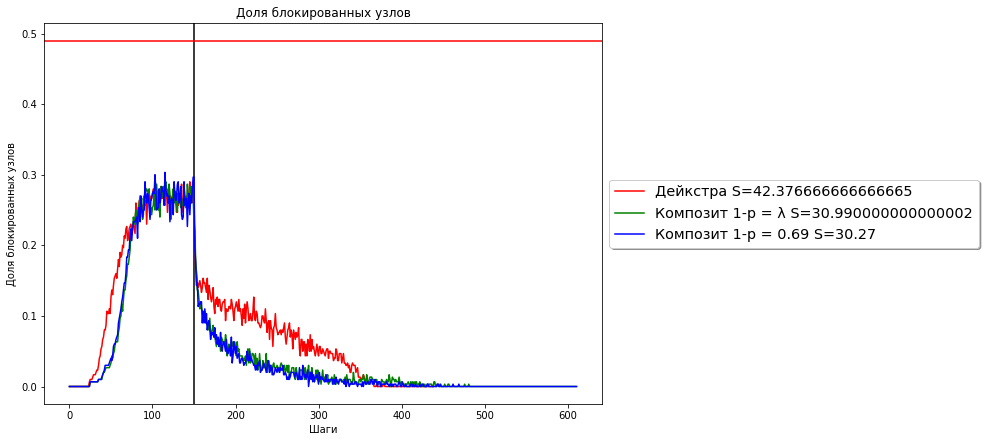

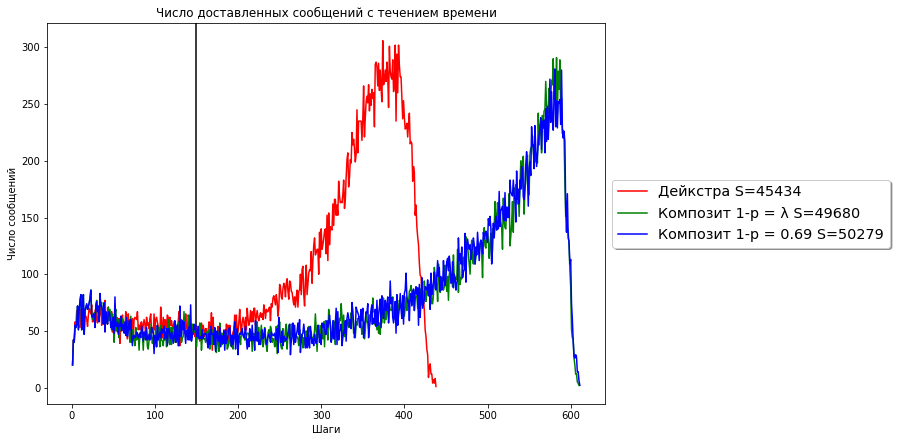

Доставлено 45197 Потеряно 76.8222% -Дейкстра
Доставлено 49728 Потеряно 74.4986% -Композит 1-p = λ
Доставлено 50034 Потеряно 74.3417% -Композит 1-p = 0.69


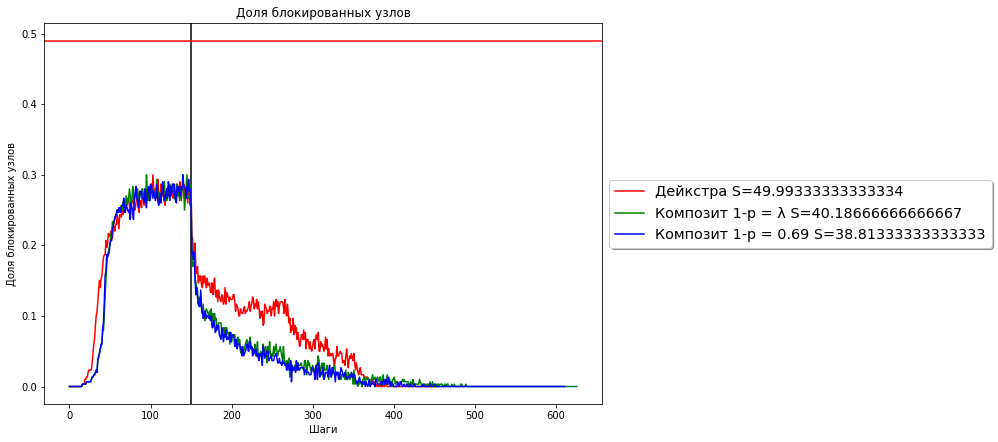

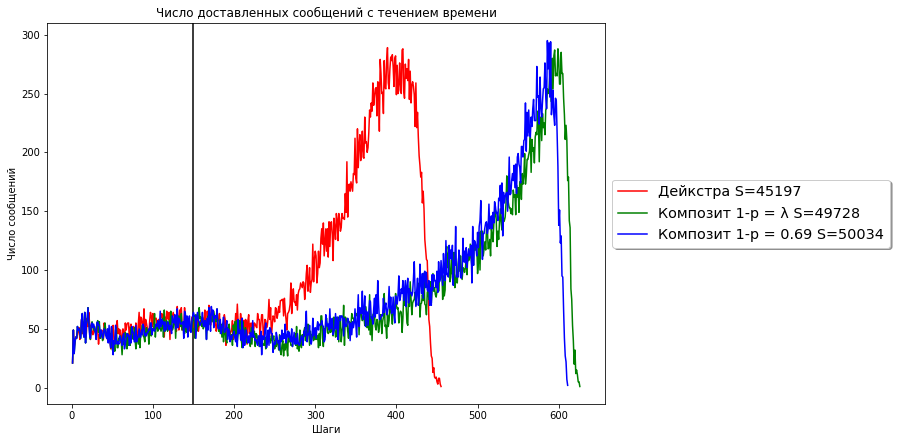

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "e026a87b-934f-40db-85ba-d4ee7c17876e", "label": "Дейкстра", "color": "red"},
 {"tag":  "2bbb2c8d-eace-4892-9024-a0f42cb7d556", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b892c509-fe76-49e3-bc22-ad0b25c1ee68", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "b1d26f3c-596a-45ca-b951-c9bf87dc0a37", "label": "Дейкстра", "color": "red"},
 {"tag":  "214a33ce-fe5d-4167-b180-9891a8c72810", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "d3e94d7f-cade-4fb3-9190-ca892bcd3653", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "28b86971-e037-4dc3-82b3-54455b7e7fa0", "label": "Дейкстра", "color": "red"},
 {"tag":  "29be19ea-4e56-4bcb-9076-cd688f4168b1", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "7198b6e6-a3b4-4f02-a471-2a0ee5688226", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "f9bbf530-0b35-44b9-a9e6-5e25448db723", "label": "Дейкстра", "color": "red"},
 {"tag":  "704c1fac-bb02-4b0b-b288-4f64719d9922", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "e84a7a8d-37c7-4d94-9da1-62123508aeaa", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

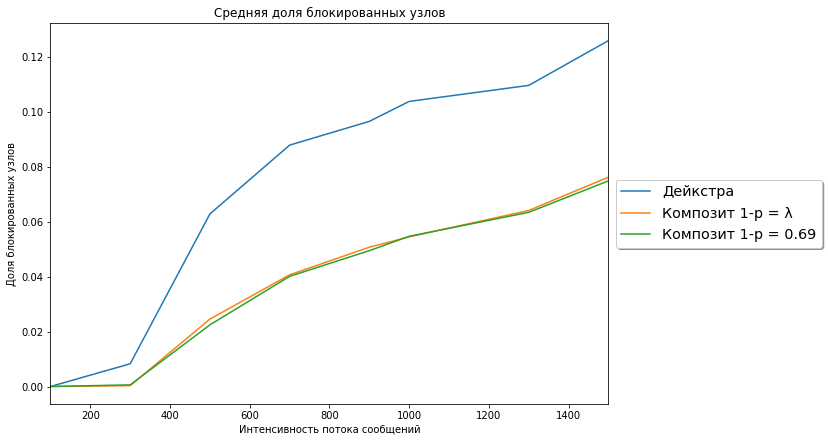

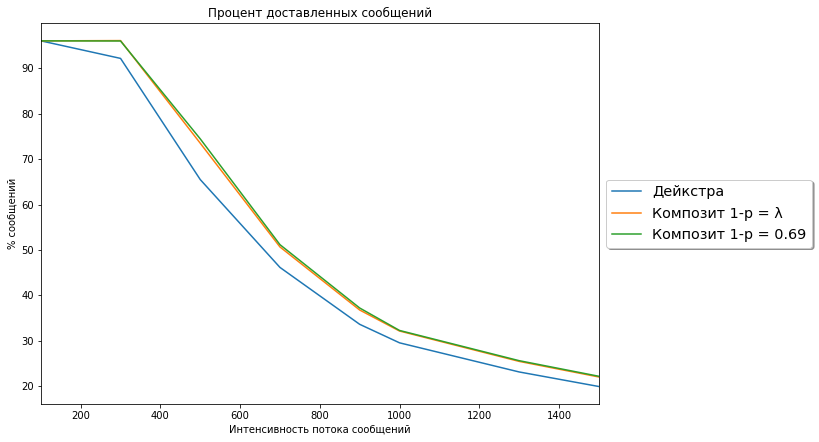

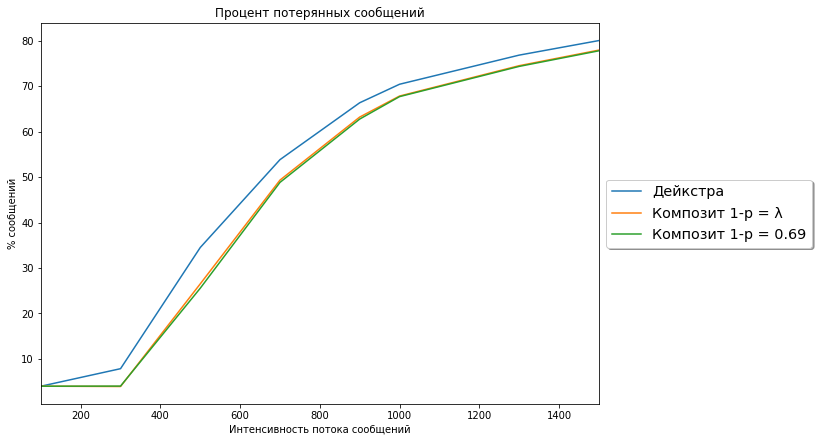

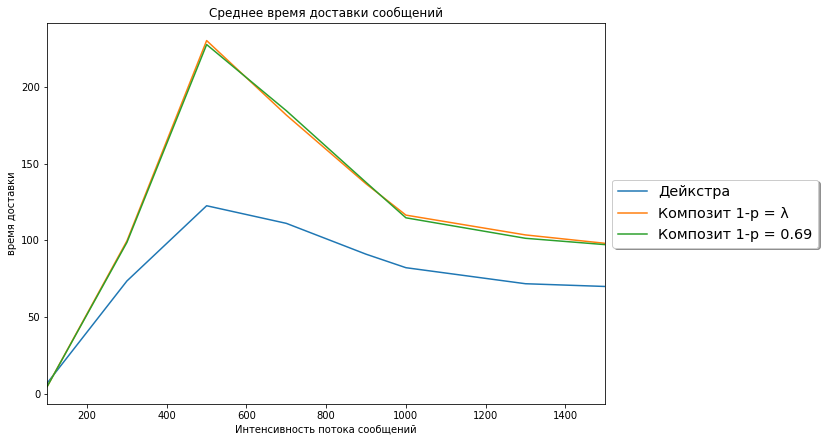

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.074362
Композит 1-p = λ       0.038882
Композит 1-p = 0.69    0.038201

Дейкстра               49.227087
Композит 1-p = λ       45.906460
Композит 1-p = 0.69    45.625111

Дейкстра                78.766565
Композит 1-p = λ       121.402848
Композит 1-p = 0.69    120.826925
